In [38]:
import copy
import os
import sys
sys.path.append("/home/diego/python/auditory-cortex/data/") 

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
# import seaborn as sns

from gglm.glm.base import GLM
from gglm.glm.mmdglm import MMDGLM
# from gglm.cnncritic import MMDCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect

from celldata import CellData

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
# path = '/home/diego/Dropbox/projects/auditory-cortex/data/ACx_data_2/ACxCalyx/20190918-xxx999-001-004/'
# path = '/home/diego/Dropbox/projects/auditory-cortex/data/ACx_data_2/ACxCalyx/'
path = '/home/diego/Dropbox/projects/auditory-cortex/data/ACx_data_2/ACxThelo/'
l = os.listdir(path)
cd = CellData(path + l[2])

# thelo 0, 2!

In [161]:
# cd.df[cd.df.type == 'fmsweep']
a = int(np.round(cd.df.trigger.diff().min() / 2)) - 1

556
556
Starting gradient ascent... 

 Iteration 45 of 200 | Elapsed time: 6.95 seconds | objective=-4091.2
 
 Iteration 45 of 200 | Converged | Elapsed time: 0.1159 minutes | Log posterior is monotonic 

-6.977620934666356


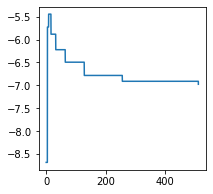

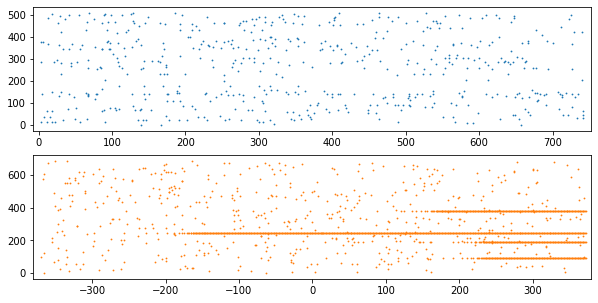

In [162]:
# dic_filter = {'type': 'fmsweep'}
# t0, tf = -300, 1800
dic_filter = {'type': 'tone'}
dic_filter = None
# t0, tf = -800, 800
t0, tf = -a, a

arg0, argf = int(t0 / cd.dt), int(tf / cd.dt)
t = np.arange(arg0, argf, 1) * cd.dt
mask_spikes = cd.get_mask_spikes_trials(dic_filter, t0=t0, tf=tf)
print(np.sum(mask_spikes))

t_sub = np.arange(t0, tf, 1)
arg_spk = np.where(mask_spikes)
t_spk = t[arg_spk[0]]
arg_spk = (np.searchsorted(t_sub, t_spk),) + arg_spk[1:]
t = t_sub[:]
mask_spikes = np.zeros((len(t), mask_spikes.shape[1]), dtype=bool)

arg_spk = (arg_spk[0][arg_spk[0] < len(t)], arg_spk[1][arg_spk[0] < len(t)])

mask_spikes[arg_spk] = True
print(np.sum(mask_spikes))

st_te = SpikeTrain(t - t[0], mask_spikes)

# eta = KernelFun.exponential([10], coefs=[-2])
# eta = KernelFun.exponential([2, 100], coefs=[-1, 1])

tbins = np.arange(0, 200, 2)
tbins = [0, 4, 8, 16, 32, 64, 128, 256, 512]
eta = KernelRect(tbins=tbins, coefs=np.zeros(len(tbins) - 1))

glm = GLM(u0=-4, eta=eta)
glm.fit(t, mask_spikes, verbose=True, newton_kwargs=dict(learning_rate=1e-1, max_iterations=200))

u, r, mask_spikes_fr = glm.sample(t, shape=(mask_spikes.shape[1],))
st_fr = SpikeTrain(t, mask_spikes_fr)

fig, ax = plt.subplots(figsize=(3, 3))
print(glm.u0)
glm.eta.plot(ax=ax, offset=glm.u0)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=2)
st_te.plot(ax=ax1, ms=0.8)
st_fr.plot(ax=ax2, ms=0.8, color='C1')

(array([547.,  58.,  53.,  13.,  12.,   0.,   2.,   0.,   1.,   1.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

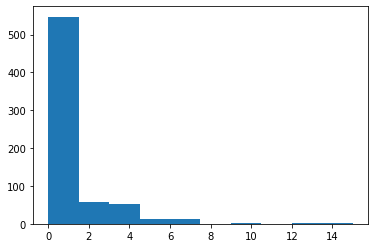

In [164]:
np.mean(np.sum(mask_spikes, 0)), np.mean(np.sum(mask_spikes_fr, 0))
plt.hist(np.sum(mask_spikes, 0), bins=)

In [165]:
0.99**100, 0.99**2

(0.3660323412732292, 0.9801)

In [147]:
# type(mat['FIRA'][0][0][0][0])
# mat['FIRA'][0][0][0][0]
# mat['FIRA'][0][2]

In [153]:
len(b)

1362

IndexError: index 11 is out of bounds for axis 1 with size 6

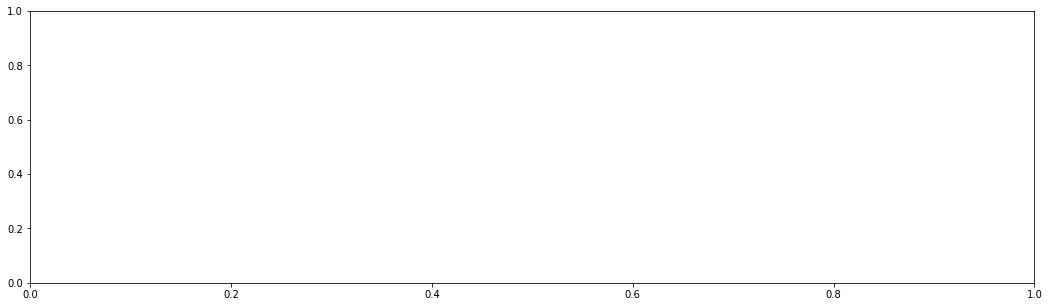

In [154]:
b = mat['FIRA'][0][2]#['task']
# a = mat['FIRA'][0][0]#['task']

fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(b[:, 11])

In [161]:
mat['FIRA'][0][2][-3][0][0][0]

array([[1229],
       [1596],
       [1768],
       [1911],
       [1953],
       [2052],
       [2124],
       [2510],
       [3663],
       [3703]], dtype=uint16)

In [188]:
mask = np.zeros((10000, 1362), dtype=bool)
for ii in range(len(mat['FIRA'][0][2])):
    aux = mat['FIRA'][0][2][ii][0][0][0]
    if len(aux) > 1:
        aux = np.array(aux[:, 0])
        mask[aux, ii] = True
#         try:
#             l.append(np.max(aux))
#         except:
#             print(aux, len(aux))

# [np.max(mat['FIRA'][0][2][ii][0][0][0]) for ii in range(len(mat['FIRA'][0][2])) if len(mat['FIRA'][0][2][ii]) > 0]

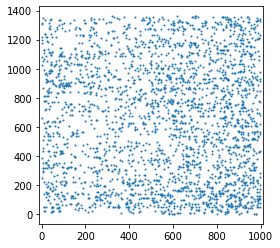

In [201]:
st = SpikeTrain(np.arange(mask.shape[0]), mask)
st = SpikeTrain(np.arange(1000), mask[:1000])
fig, ax = plt.subplots(figsize=(4, 4))
st.plot(ax=ax, ms=1)